#**Overview:**

In this notebook the ViT models are trained and evaluated. The results and weights of each model and experiment are saved to a file for future comparison. The highest performing model is then used for the final image embeddings that will be used in the multimodal model. Finally the same model is then evaluated on it's own on the test data to serve as a benchmark.

#**Importing necessary packages and libraries**

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import cv2
import re
import albumentations as A
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from transformers import ViTForImageClassification, AdamW, Trainer, TrainingArguments,  ViTImageProcessor, AutoImageProcessor, AutoModelForImageClassification, AutoImageProcessor, AutoModel, AutoConfig
from PIL import Image
from torch import nn

In [ ]:
#setting the model's name for the experiment:
model_names = ["google/vit-base-patch16-224-in21k",
               "google/vit-large-patch16-224-in21k",
               "google/vit-base-patch32-224-in21k",
               "google/vit-large-patch32-224-in21k",
               "google/vit-base-patch16-384",
               "google/vit-large-patch16-384"]

model_name = model_names[0] #select model name
filename = model_name.split('/')[1] #without the /google part
size = int(re.findall(r'\d+', model_name)[1]) # the image size the model takes as imput

print("Experiment using:",filename,"\nimage size is: "+str(size)+"x"+str(size)+" pixels")

Experiment using: vit-base-patch16-224-in21k 
image size is: 224x224 pixels


#**Loading data and images from google drive**

In [ ]:
#load dataframe
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Dissertation/Images/pneumonia_1519_PAAP.csv')

Mounted at /content/drive


In [ ]:
#load images
with open(f'/content/drive/My Drive/Dissertation/Images/image_list_1519_{size}.pkl', 'rb') as f:
    images = pickle.load(f)

#making sure the image list and dataframe loaded have the same length
assert len(images) == len(df)

In [ ]:
#saving image arrays to a new column in the dataframe
df['image'] = images
print(df['image'][0].shape)

(224, 224)


In [ ]:
# test to see if removing -1 label increases performance
df = df[df['pneumonia']!=-1]

#**Optional data filtering ( view position etc)**

In [ ]:
# also consider data augmentation with transforms (after train val test split)
# only keep images with AP and PA orientations
df = df[df['ViewPosition'].isin(['AP','PA'])]
images = df['image']
assert len(images) == len(df)
df

,dicom_id,subject_id,study_id,ViewPosition,img_path,pneumonia,split,image
0,043f2b1c-1b8b0a20-c9e5ec5d-02ac7d4a-35000b4c,15000170,56450978,PA,files/p15/p15000170/s56450978/043f2b1c-1b8b0a2...,0.0,train,"[[2, 3, 3, 2, 2, 5, 4, 4, 4, 5, 3, 3, 4, 3, 4,..."
1,39ee0432-150f8ee9-e65abf9a-15bc5beb-80fbf3f6,15000393,51634677,PA,files/p15/p15000393/s51634677/39ee0432-150f8ee...,0.0,train,"[[233, 162, 142, 128, 137, 111, 106, 104, 104,..."
2,80eeb158-92ef7719-b43ae606-fb2745cf-99680d44,15000393,51634677,PA,files/p15/p15000393/s51634677/80eeb158-92ef771...,0.0,train,"[[103, 57, 21, 11, 9, 8, 7, 6, 6, 6, 6, 6, 6, ..."
3,8a2da5f5-09ea301d-768e059c-5f053a34-2d3b3057,15000393,52929930,PA,files/p15/p15000393/s52929930/8a2da5f5-09ea301...,1.0,train,"[[6, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
4,b08efb71-38c915e9-3d9d7df0-d783d4d6-1317bf59,15000393,54674484,PA,files/p15/p15000393/s54674484/b08efb71-38c915e...,0.0,train,"[[245, 239, 217, 202, 194, 197, 214, 212, 228,..."
...,...,...,...,...,...,...,...,...
30677,0802e3d3-5c5c09e8-eddfff18-c451289a-1fb33127,19997367,56428935,AP,files/p19/p19997367/s56428935/0802e3d3-5c5c09e...,0.0,train,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 59..."
30680,a29987d8-abd13298-7a067b12-620f9fdb-103ecf53,19998330,54053771,AP,files/p19/p19998330/s54053771/a29987d8-abd1329...,1.0,train,"[[75, 75, 74, 75, 77, 74, 77, 77, 78, 73, 72, ..."
30681,518011e2-346dbd44-3e738335-c5006bf8-d69f6b68,19998770,51149538,AP,files/p19/p19998770/s51149538/518011e2-346dbd4...,0.0,train,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
30682,1427ad57-5bf4f3e6-90be02f3-d1760987-99d7f2ce,19998843,56350227,AP,files/p19/p19998843/s56350227/1427ad57-5bf4f3e...,1.0,train,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


#**Image and Label Preprocessing to match ViT input**

In [ ]:


# # resizing images to 224x224 or 384x384 and converting to rgb to fit the transformer model
n = int(re.findall(r'\d+', model_name)[1])
dim = (size,size)
import cv2
img = []
i=0
for image in images:
  if image.shape != dim:
    print("the image needs to be scaled")
    break
    rgb = cv2.resize(image, dim)
    rgb = np.stack((rgb,)*3, axis=0)
    if i==0:
      print("the image has been scaled")
  else:
    rgb = np.stack((image,)*3, axis=0)

  img.append(rgb)
  i+=1


df.loc[:,'image'] = img
print(df['image'].iloc[0].shape,type(df['image'].iloc[0]))

(3, 224, 224) <class 'numpy.ndarray'>


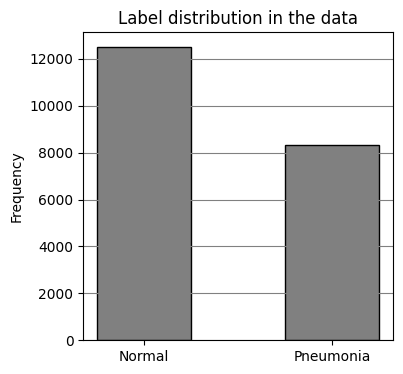

In [ ]:
#converting labels to integers
labels = [label for label in df['pneumonia']]
for i in range(len(labels)):
  if labels[i]==-1:
    labels[i]=2
df['pneumonia'] = [int(label) for label in labels]

# plt.figure(figsize=(4, 5))
# plt.hist(df['pneumonia'], bins=[-0.5,0.5,1.5], color = 'seagreen',edgecolor='black', align='mid')

# plt.title('Histogram of Pneumonia labels in the dataset')
# plt.ylabel('Frequency')
# plt.xticks([0, 1])
# plt.show()

#frequency before balancing
plt.figure(figsize=(4,4))
plt.hist(df['pneumonia'], bins=[-0.5,0.5, 1.5], color = 'grey',edgecolor='black', align='mid',rwidth = 0.5)
plt.title('Label distribution in the data')
plt.ylabel('Frequency')
plt.grid(True, axis='y', color='grey')
plt.yticks([i for i in range(0,df['pneumonia'].value_counts()[0],2000)])
plt.xticks([0, 1], ['Normal', 'Pneumonia'])
plt.yticks()
plt.show()

#**Loading the ViT Model**

In [ ]:
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
# configuring the model to change the classifcation head, and adding dropout to the hidden layers
config = AutoConfig.from_pretrained(model_name)
config.num_labels = 2
config.hidden_dropout_prob = 0.3
config.attention_probs_dropout_prob = 0.1

model = AutoModelForImageClassification.from_pretrained(model_name, config=config,ignore_mismatched_sizes=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#**Data Preparation**

In [ ]:
#defining a dataset class to handle the image processing using the processor from the hugging face model
class PneumoniaDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.images = df['image'].values
        self.labels = df['pneumonia'].values
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image = self.images[idx]
        inputs = self.processor(images=image, return_tensors="pt")
        image_tensor = inputs['pixel_values'].squeeze(0)  #removing the batch dimension
        label = torch.tensor(self.labels[idx], dtype=torch.long).clone().detach()
        return image_tensor, label

# defining the augmentation/transformation pipeline
prob = 1.0
image_transform = A.Compose([
    A.Rotate(limit=40, p=prob),  # Random rotation within the range [-40, 40] degrees
    A.HorizontalFlip(p=0.5),  # Random horizontal flip
    A.VerticalFlip(p=0.5),  # Random vertical flip
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=prob),  # Random shifting across height and width by 10%
    A.RandomBrightnessContrast(brightness_limit=[-0.5, 0.5], contrast_limit=0, p=prob),  # Random brightness adjustment
    A.Affine(shear={"x": (-10, 10)}, p=prob),  # Random shearing counterclockwise direction [0, 0.1] radians (10 degrees)
    A.RandomScale(scale_limit=0.1, p=prob),  # Random zooming within the range [0.9, 1.1]
    # A.Normalize(mean=(0, 0, 0), std=(255, 255, 255), max_pixel_value=1.0)  # Rescaling by 1/255 this is handled by the model's processor
])


def transform_image(image):
    image = np.transpose(image, (1, 2, 0))  # Convert from CHW to HWC
    augmented = image_transform(image=image)
    augmented_image = augmented['image']
    augmented_image = np.transpose(augmented_image, (2, 0, 1))  # Convert back to CHW
    return augmented_image

###**Splitting data to train and validation sets and applying data balancing to the training set**

In [ ]:
# function for balancing using undersampling
def data_bal_under(df,label,values):
  #size of minority class
  n = min(df[label].value_counts())
  #separate the dataframe by the three classes
  df_class0 = df[df[label] == values[0]]
  df_class1 = df[df[label] == values[1]]
  # df_class2 = df[df[label] == values[2]]
  #undersampling to balance the classes
  df_class0 = resample(df_class0, replace=False, n_samples=n)
  df_class1 = resample(df_class1, replace=False, n_samples=n)
  # df_class2 = resample(df_class2, replace=False, n_samples=n)
  #merge the three classes back to a single dataframe
  df_balanced = pd.concat([df_class0, df_class1], axis=0)
  df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

  return df_balanced

#function for data balancing using over sampling new data is created by appliying trasnformations to the images of the minority class
def data_bal_over(df,label,values):
  #size of majority class
  m = max(df[label].value_counts())
  #separate the dataframe by the three classes
  df_class0 = df[df[label] == values[0]]
  df_class1 = df[df[label] == values[1]]
  #oversampling to balance the classes using random image transformations
  df_class0_over = df_class0.sample(m-len(df_class0),replace=True)
  df_class0_over['image'] = df_class0_over['image'].apply(transform_image)
  df_class1_over = df_class1.sample(m-len(df_class1),replace=True)
  df_class1_over['image'] = df_class1_over['image'].apply(transform_image)

  #merge the three classes back to a single dataframe
  df_balanced = pd.concat([df_class0, df_class1, df_class0_over,df_class1_over], axis=0)
  df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)
  return df_balanced

#using the proposed data split
train = df[df['split']=='train']
val = df[df['split']=='validate']
test = df[df['split']=='test']

#balanace the classes of the training data
train = data_bal_under(train,'pneumonia',[0,1])

val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

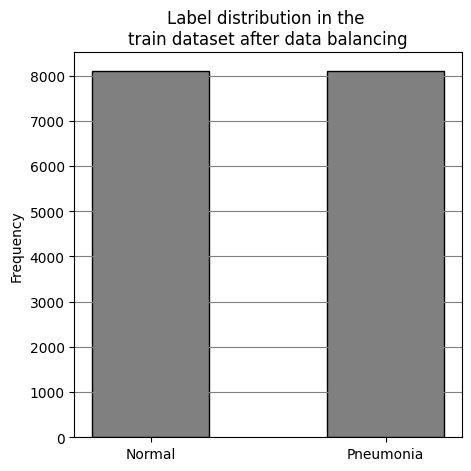

In [ ]:
plt.figure(figsize=(5, 5))
plt.hist(train['pneumonia'], bins=[-0.5,0.5,1.5], color = 'grey',edgecolor='black', align='mid', rwidth=0.5)
plt.title('Label distribution in the \ntrain dataset after data balancing')
plt.ylabel('Frequency')
plt.grid(True, axis='y', color='grey')
plt.xticks([0, 1],['Normal', 'Pneumonia'])
plt.yticks()
plt.show()

###**Apply Transformations to increase size of training data**

In [ ]:
#Has already been applied only to new images for data balancing, optionally can be used to create even more data

# Applying augmentations to all images in the training set
train2 = train.copy()
train3 = train.copy()
train2['image'] = train2['image'].apply(transform_image)
train3['image'] = train3['image'].apply(transform_image)

In [ ]:

# for i in range(4):

#   image1 = train['image'].iloc[i]
#   image1 = np.transpose(image1, (1, 2, 0))
#   image2 = train2['image'].iloc[i]
#   image2 = np.transpose(image2, (1, 2, 0))
#   # image3 = train3['image'].iloc[i]
#   # image3 = np.transpose(image3, (1, 2, 0))

#   fig, axs = plt.subplots(1,2, figsize=(10,5))
#   axs[0].imshow(image1, cmap = 'gray')
#   axs[1].imshow(image2, cmap = 'gray')
#   # axs[2].imshow(image3, cmap = 'gray')
#   axs[0].axis('off')
#   axs[1].axis('off')
#   # axs[2].axis('off')
#   axs[0].set_title('original image')
#   axs[1].set_title('transposed image')
#   # axs[2].set_title('transposed image')
#   plt.show()

In [ ]:
# adding the transformed images to the training data
train = pd.concat([train,train2,train3],axis=0)
train = train.sample(frac=1).reset_index(drop=True)
len(train), len(train2), len(train3)

#or alternatively transform all images
# train = train2

(48666, 16222, 16222)

###**Create data loaders**

In [ ]:
#using PneumoniaDataset function to create the datasets
train_dataset = PneumoniaDataset(train,processor)
val_dataset = PneumoniaDataset(val,processor)
test_dataset = PneumoniaDataset(test,processor)

#creating dataloaders set to workers to 2 when using T4 and batches to 32
workers = 4
batches = 16
# train_loader = DataLoader(train_dataset, batch_size = batches, shuffle = True, num_workers = workers, pin_memory = True)
# val_loader = DataLoader(val_dataset, batch_size = batches, shuffle = False, num_workers = workers, pin_memory = True)
# test_loader = DataLoader(test_dataset, batch_size = batches, shuffle = False, num_workers = workers, pin_memory = True)

train_loader = DataLoader(train_dataset, batch_size = batches, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batches, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batches, shuffle = False)

train['pneumonia'].value_counts()

,count
pneumonia,
0,24333
1,24333


In [ ]:
# checking to see if the tensor is the right shape
train_dataset[0][0].shape

torch.Size([3, 224, 224])

#**Loading the Model**

In [ ]:
# loading modal to gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

#**Model Training**

In [ ]:
#define hyper parameters

hp = {
    'optimiser'      : 'AdamW',
    'learning_rate'  : 5e-5,
    'weight_decay'   : 1e-2,
    'label_smoothing': 0.1,
    'epochs'         : 10
}

optimiser = torch.optim.AdamW(model.parameters(), lr=hp['learning_rate'],weight_decay = hp['weight_decay'])

criterion = CrossEntropyLoss(label_smoothing=hp['label_smoothing'])

epochs = hp['epochs']
model.train()
for epoch in range(epochs):
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs.logits, labels)

        # Backward pass and optimization
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        running_loss += loss.item()
        # Collect predictions and labels
        _, preds = torch.max(outputs.logits, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    # Calculate accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy * 100:.2f}%")
    #save the model checkpoint after each epoch
    torch.save(model.state_dict(), f'/content/drive/MyDrive/Dissertation/Images/Models/{filename}_epoch_{epoch+1}.pth')
    #early stopping if accuracy is too high can resume training if necessary
    if accuracy > 0.99:
      print( "overfitting likely, stopped at epoch:",epoch+1)
      epochs = epoch+1
      break

100%|██████████| 3042/3042 [08:17<00:00,  6.11it/s]


Epoch [1/10], Loss: 0.6515, Accuracy: 62.20%


100%|██████████| 3042/3042 [08:18<00:00,  6.10it/s]


Epoch [2/10], Loss: 0.6172, Accuracy: 67.77%


100%|██████████| 3042/3042 [08:18<00:00,  6.10it/s]


Epoch [3/10], Loss: 0.6027, Accuracy: 69.62%


100%|██████████| 3042/3042 [08:14<00:00,  6.15it/s]


Epoch [4/10], Loss: 0.5906, Accuracy: 70.96%


100%|██████████| 3042/3042 [08:15<00:00,  6.14it/s]


Epoch [5/10], Loss: 0.5777, Accuracy: 72.14%


100%|██████████| 3042/3042 [08:14<00:00,  6.15it/s]


Epoch [6/10], Loss: 0.5667, Accuracy: 73.45%


100%|██████████| 3042/3042 [08:14<00:00,  6.15it/s]


Epoch [7/10], Loss: 0.5509, Accuracy: 75.13%


100%|██████████| 3042/3042 [08:14<00:00,  6.15it/s]


Epoch [8/10], Loss: 0.5343, Accuracy: 76.66%


100%|██████████| 3042/3042 [08:14<00:00,  6.15it/s]


Epoch [9/10], Loss: 0.5185, Accuracy: 78.02%


100%|██████████| 3042/3042 [08:17<00:00,  6.12it/s]


Epoch [10/10], Loss: 0.4998, Accuracy: 79.66%


#**Model Evaluation**

In [ ]:
#taking a random sample from the training data for comparison
size = int(len(val_dataset))
ridx = torch.randperm(len(train_dataset))[:size]
train_sample = torch.utils.data.Subset(train_dataset, ridx)
train_sample_loader = DataLoader(train_sample, batch_size=batches, shuffle=False)
int(size/batches+1)

9

In [ ]:
# model.load_state_dict(torch.load('/content/drive/MyDrive/vit_pneumonia_epoch_1.pth'))
all_preds_val = []
all_labels_val = []
all_preds_train = []
all_labels_train = []
for epoch in range(epochs) :

  model.load_state_dict(torch.load(f'/content/drive/MyDrive/Dissertation/Images/Models/{filename}_epoch_{epoch+1}.pth',weights_only=True))

  model.eval()

  epoch_preds_val=[]
  epoch_labels_val=[]
  epoch_preds_train=[]
  epoch_labels_train=[]
  with torch.no_grad():
    for images, labels in tqdm(val_loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, preds = torch.max(outputs.logits, 1)
      epoch_preds_val.extend(preds.cpu().numpy())
      epoch_labels_val.extend(labels.cpu().numpy())

    for images, labels in tqdm(train_sample_loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, preds = torch.max(outputs.logits, 1)
      epoch_preds_train.extend(preds.cpu().numpy())
      epoch_labels_train.extend(labels.cpu().numpy())

    # Calculate accuracy
    val_accuracy = accuracy_score(epoch_labels_val, epoch_preds_val)
    train_accuracy = accuracy_score(epoch_labels_train, epoch_preds_train)

    # Print results
    print(f'Epoch {epoch+1}')
    print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    all_preds_val.append(epoch_preds_val)
    all_labels_val.append(epoch_labels_val)
    all_preds_train.append(epoch_preds_train)
    all_labels_train.append(epoch_labels_train)

100%|██████████| 9/9 [00:00<00:00, 12.50it/s]


Epoch 1
Validation Accuracy: 66.17%
Training Accuracy: 66.92%


100%|██████████| 9/9 [00:00<00:00, 12.67it/s]


Epoch 2
Validation Accuracy: 69.92%
Training Accuracy: 68.42%


100%|██████████| 9/9 [00:00<00:00, 12.97it/s]


Epoch 3
Validation Accuracy: 66.92%
Training Accuracy: 69.92%


100%|██████████| 9/9 [00:00<00:00, 12.80it/s]


Epoch 4
Validation Accuracy: 69.92%
Training Accuracy: 72.18%


100%|██████████| 9/9 [00:00<00:00, 13.06it/s]


Epoch 5
Validation Accuracy: 75.19%
Training Accuracy: 74.44%


100%|██████████| 9/9 [00:00<00:00, 12.90it/s]


Epoch 6
Validation Accuracy: 67.67%
Training Accuracy: 77.44%


100%|██████████| 9/9 [00:00<00:00, 12.73it/s]


Epoch 7
Validation Accuracy: 68.42%
Training Accuracy: 80.45%


100%|██████████| 9/9 [00:00<00:00, 12.43it/s]


Epoch 8
Validation Accuracy: 71.43%
Training Accuracy: 80.45%


100%|██████████| 9/9 [00:00<00:00, 12.12it/s]


Epoch 9
Validation Accuracy: 71.43%
Training Accuracy: 84.21%


100%|██████████| 9/9 [00:00<00:00, 12.76it/s]

Epoch 10
Validation Accuracy: 69.17%
Training Accuracy: 81.95%


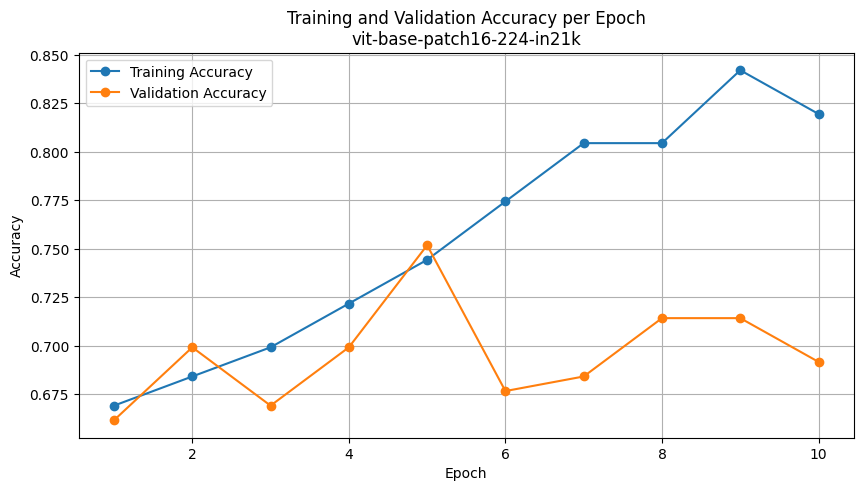

In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store accuracy values for each epoch
train_accuracies = []
val_accuracies = []
# Calculate accuracy for each epoch
for epoch in range(epochs):
    # Training accuracy
    train_accuracy = accuracy_score(all_preds_train[epoch],all_labels_train[epoch])
    train_accuracies.append(train_accuracy)

    # Validation accuracy
    val_accuracy = accuracy_score(all_preds_val[epoch],all_labels_val[epoch])
    val_accuracies.append(val_accuracy)

# Plotting the accuracies
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title(f'Training and Validation Accuracy per Epoch\n{filename}')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from IPython.display import Audio
def beep():
  return  Audio(0.00025 * np.sin(2 * np.pi * 880 * np.linspace(0, 0.15, int(44100 * 0.15), endpoint=False)),rate=44100, autoplay=True)

In [ ]:
display(beep())

The model achieved the highest accuracy on the validation set after training for 5 epochs


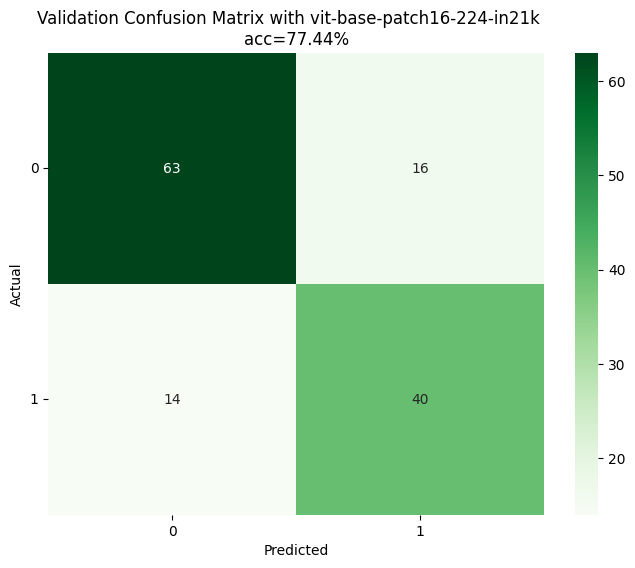

In [ ]:
import seaborn as sns

max_val_acc = 0
for i in range(epochs):
  if val_accuracies[i] > max_val_acc:
    max_val_acc = val_accuracies[i]
    best_epoch = i
# best_epoch = 0
print("The model achieved the highest accuracy on the validation set after training for",best_epoch+1,"epochs")
#print confusion matrix for the epoch with the highest validation accuracy
conf_matrix = confusion_matrix(all_labels_val[best_epoch], all_preds_val[best_epoch])
accuracy = accuracy_score(all_labels_val[best_epoch], all_preds_val[best_epoch])
labels = ['0', '1']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Validation Confusion Matrix with {filename}   \nacc='+str(round(100*accuracy,2))+'%')
plt.show()

In [ ]:
print(classification_report(all_labels_val[best_epoch], all_preds_val[best_epoch]))

              precision    recall  f1-score   support

           0       0.77      0.82      0.80        79
           1       0.71      0.65      0.68        54

    accuracy                           0.75       133
   macro avg       0.74      0.74      0.74       133
weighted avg       0.75      0.75      0.75       133



In [ ]:
# save accuracies and predictions to file for comparison with other models
filename = model_name.split('/')[1]
with open(f'/content/drive/MyDrive/Dissertation/Images/Models/scores/{filename}.pkl', 'wb') as f:
    pickle.dump({
        'train_accuracies': train_accuracies,
        'train_preds':all_preds_train,
        'train_labels':all_labels_train,
        'val_accuracies': val_accuracies,
        'val_preds':all_preds_val,
        'val_labels':all_labels_val,
        'best_epoch':best_epoch,
        'hp':hp
        }, f)


In [ ]:
#check to see if file was saved correctly
with open(f'/content/drive/MyDrive/Dissertation/Images/Models/scores/{filename}.pkl', 'rb') as f:
    accuracies = pickle.load(f)

train_accuracies1 = accuracies['train_accuracies']
val_accuracies1 = accuracies['val_accuracies']
all_preds_val1 = accuracies['val_preds']
all_labels_val1 = accuracies['val_labels']
all_preds_train1 = accuracies['train_preds']
all_labels_train1 = accuracies['train_labels']
assert train_accuracies1 == train_accuracies
assert val_accuracies1 == val_accuracies
assert all_preds_val1 == all_preds_val
assert all_labels_val1 == all_labels_val
assert all_preds_train1 == all_preds_train
assert all_labels_train1 == all_labels_train

In [ ]:
best_epoch

4

#Evaluating the model on the unseen test data

In [ ]:

preds_test = []
labels_test = []

#load the best model based on validation performance
filename = 'vit-base-patch16-224-in21k'
best_epoch=3
model.load_state_dict(torch.load(f'/content/drive/MyDrive/Dissertation/Images/Models/{filename}_epoch_{best_epoch+1}.pth',weights_only=True))

model.eval()

with torch.no_grad():
  for images, labels in tqdm(test_loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.logits, 1)
    preds_test.extend(preds.cpu().numpy())
    labels_test.extend(labels.cpu().numpy())


  # Calculate accuracy
  test_accuracy = accuracy_score(labels_test, preds_test)

  # Print results
  print('test Accuracy:', test_accuracy)

100%|██████████| 21/21 [00:04<00:00,  5.21it/s]

test Accuracy: 0.7009063444108762


In [ ]:
print(classification_report(labels_test,preds_test,digits=4))

              precision    recall  f1-score   support

           0     0.7101    0.6242    0.6644       157
           1     0.6943    0.7701    0.7302       174

    accuracy                         0.7009       331
   macro avg     0.7022    0.6972    0.6973       331
weighted avg     0.7018    0.7009    0.6990       331



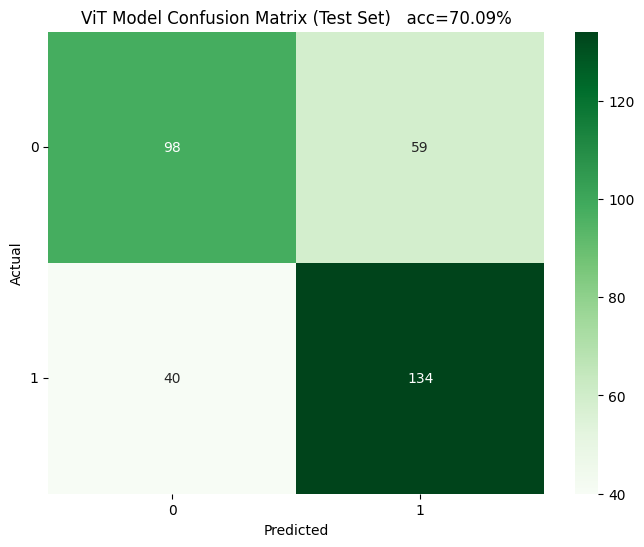

In [ ]:
conf_matrix = confusion_matrix(labels_test, preds_test)
accuracy = accuracy_score(labels_test, preds_test)
labels = ['0', '1']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xticks(np.arange(len(labels)) + 0.5, labels)
plt.yticks(np.arange(len(labels)) + 0.5, labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ViT Model Confusion Matrix (Test Set)   acc='+str(round(100*accuracy,2))+'%')
plt.show()